In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error

In [21]:
# a+b Load dataset and splitting
data = load_breast_cancer()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape
X_test.shape

(114, 30)

#(c)
Logistic Regression Objective with L2 regularization:
J(w, b) = (1/N) * sum [ -y_i log sigma(z_i) - (1-y_i) log(1 - sigma(z_i)) ] + (lambda/2) ||w||**2

where z_i = w^T x_i + b and sigma(z) = sigmoid(z).

We’ll implement it using sklearn's LogisticRegression.

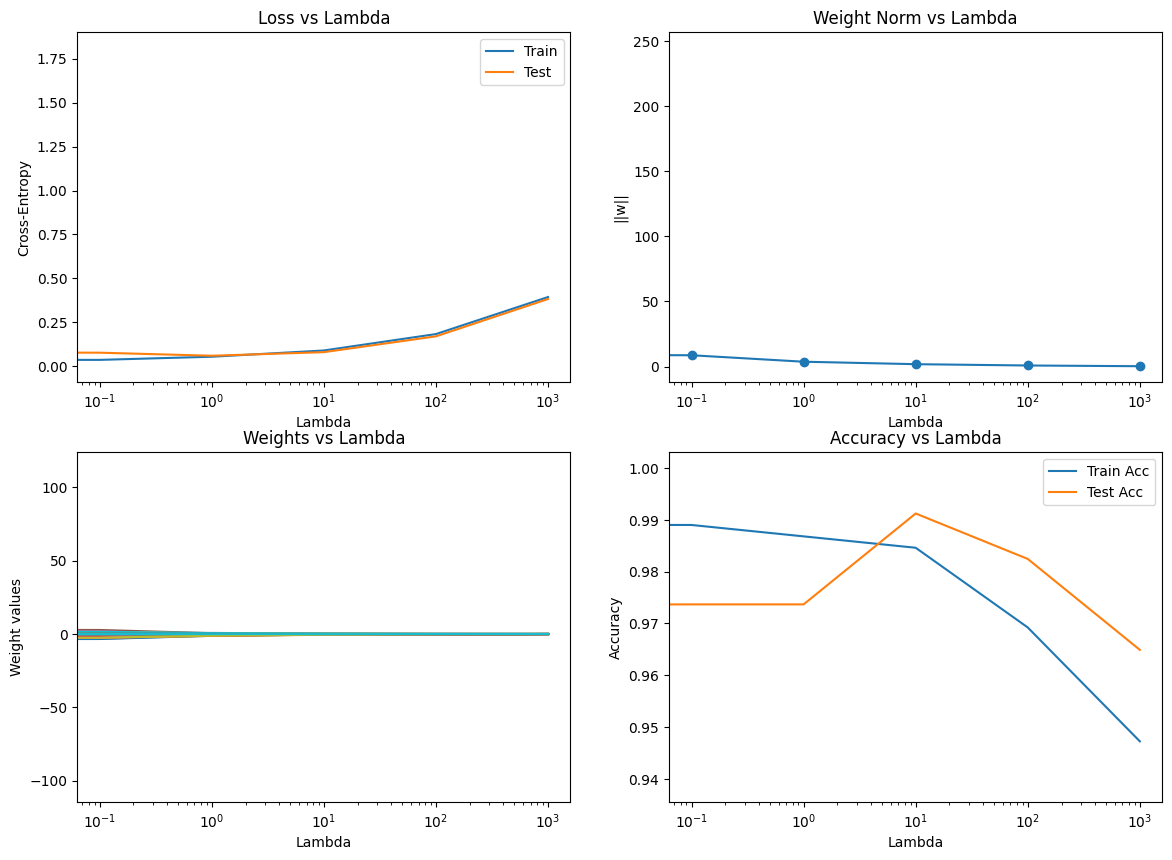

In [22]:
lambdas = [0, 0.1, 1, 10, 100, 1000]

# Lists to store metrics for each λ
# Cross-entropy losses
train_losses, test_losses = [], []

# L2 norms of weight vector
norms = []

# Accuracies on train/test sets
acc_train, acc_test = [], []

# Learned weights for each λ
weights = []

# Loop over different λ values
for lam in lambdas:
    # Logistic Regression with L2 regularization

    clf = LogisticRegression(
        penalty='l2',
        C=1/(lam+1e-6),   # add 1e-6 to avoid division by zero when λ = 0
        solver='liblinear',
        max_iter=1000
    )

    # Train the model
    clf.fit(X_train, y_train)

    # Predict probabilities
    y_pred_train = clf.predict_proba(X_train)
    y_pred_test = clf.predict_proba(X_test)

    # Compute cross-entropy loss for training and testing
    train_losses.append(log_loss(y_train, y_pred_train))
    test_losses.append(log_loss(y_test, y_pred_test))

    # Compute L2 norm
    norms.append(np.linalg.norm(clf.coef_))

    acc_train.append(accuracy_score(y_train, clf.predict(X_train)))
    acc_test.append(accuracy_score(y_test, clf.predict(X_test)))
    weights.append(clf.coef_.flatten())


# (d) Plots
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(lambdas, train_losses, label="Train")
plt.plot(lambdas, test_losses, label="Test")
plt.xscale('log'); plt.xlabel("Lambda"); plt.ylabel("Cross-Entropy"); plt.legend(); plt.title("Loss vs Lambda")

plt.subplot(2,2,2)
plt.plot(lambdas, norms, marker='o')
plt.xscale('log'); plt.xlabel("Lambda"); plt.ylabel("||w||"); plt.title("Weight Norm vs Lambda")

plt.subplot(2,2,3)
for i in range(len(weights[0])):
    plt.plot(lambdas, [w[i] for w in weights])
plt.xscale('log'); plt.xlabel("Lambda"); plt.ylabel("Weight values"); plt.title("Weights vs Lambda")

plt.subplot(2,2,4)
plt.plot(lambdas, acc_train, label="Train Acc")
plt.plot(lambdas, acc_test, label="Test Acc")
plt.xscale('log'); plt.xlabel("Lambda"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy vs Lambda")
plt.show()


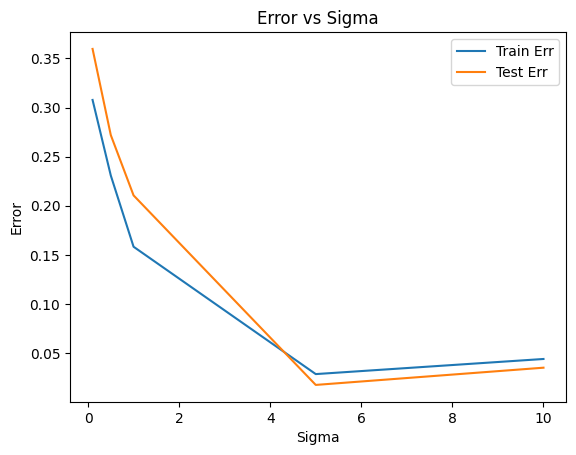

In [23]:
# (e) Gaussian basis expansion

# Function to create Gaussian basis features
def gaussian_basis(X, sigma):
    means = np.linspace(-10, 10, 5)
    new_feats = []
    for col in X.T:
        # For each mean, create a Gaussian basis function
        for mu in means:
            new_feats.append(np.exp(- (col - mu)**2 / (2*sigma**2)))
    return np.vstack(new_feats).T

# Different sigma values for experiment
sigmas = [0.1, 0.5, 1, 5, 10]
train_errors, test_errors = [], []

# Loop over each sigma
for s in sigmas:
    # Expand training and test sets using Gaussian basis functions
    X_train_g = gaussian_basis(X_train, s)
    X_test_g = gaussian_basis(X_test, s)

    model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='saga')
    model.fit(X_train_g, y_train)

    # Calculate training and test classification errors
    train_errors.append(1 - accuracy_score(y_train, model.predict(X_train_g)))
    test_errors.append(1 - accuracy_score(y_test, model.predict(X_test_g)))

# Plot training and test error vs sigma
plt.figure()
plt.plot(sigmas, train_errors, label="Train Err")
plt.plot(sigmas, test_errors, label="Test Err")
plt.xlabel("Sigma")
plt.ylabel("Error")
plt.title("Error vs Sigma")
plt.legend()
plt.show()


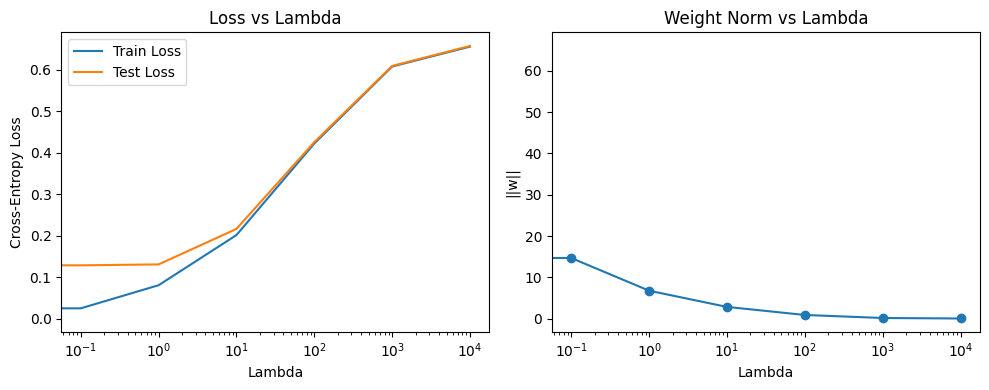

In [24]:
# (g) Regularized regression with all sigmas combined

# Combine Gaussian basis features for all sigma values
X_train_all = np.hstack([gaussian_basis(X_train, s) for s in sigmas])
X_test_all = np.hstack([gaussian_basis(X_test, s) for s in sigmas])

lambdas_ext = [0, 0.1, 1, 10, 100, 1000, 10000]
train_losses2, test_losses2, norms2 = [], [], []

# Loop over extended lambda values
for lam in lambdas_ext:
    clf = LogisticRegression(
        penalty='l2',
        C=1/(lam+1e-6),
        solver='liblinear',
        max_iter=1000
    )
    clf.fit(X_train_all, y_train)

    # Predictions for log-loss
    y_pred_train = clf.predict_proba(X_train_all)
    y_pred_test = clf.predict_proba(X_test_all)

    # Store cross-entropy losses
    train_losses2.append(log_loss(y_train, y_pred_train))
    test_losses2.append(log_loss(y_test, y_pred_test))

    # Store norm of weights
    norms2.append(np.linalg.norm(clf.coef_))

# Plot the results
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(lambdas_ext, train_losses2, label='Train Loss')
plt.plot(lambdas_ext, test_losses2, label='Test Loss')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs Lambda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(lambdas_ext, norms2, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('||w||')
plt.title('Weight Norm vs Lambda')

plt.tight_layout()
plt.show()


#(h) Explain what you would need to do if you wanted to design a set of Gaussian basis functionsthat capture relationships between the inputs. Explain the impact of this choice the bias-variance trade-off.

Designing Gaussian basis functions that capture input relationships requires multivariate Gaussians, where each basis depends on multiple features together (not individually).
This allows the model to represent feature interactions more effectively.
It reduces bias because the model becomes more flexible.
However, it increases variance, as more parameters can lead to overfitting.
Thus, the bias-variance trade-off shifts: lower bias but higher variance, requiring careful regularization.

#(i) Suppose that instead of wanting to use a fixed set of evenly-spaced basis functions, you wouldlike to adapt the placement of these functions. Derive a learning algorithm that computes both the placement of the basis function, μi and the weight vector w from data (assuming that the width σ isfixed. You should still allow for L2 regularization of the weight vector.Note that your algorithm will need to be iterative.)


Define each Gaussian basis as: phi_j(x, mu_j) = exp( - ||x - mu_j||^2 / (2 * sigma^2) ), where sigma is fixed and mu_j is the center.
Build the design matrix Phi whose columns are the basis function outputs for all training points.
Use a regularized least-squares objective: (1/2n) * ||Phi * w - y||^2 + (lambda/2) * ||w||^2.
For fixed centers mu_j, the optimal weight vector w is the ridge solution: w = (Phi^T Phi + nlambdaI)^{-1} Phi^T y.
To move a center mu_j, compute the gradient of the objective w.r.t. mu_j using residuals (Phi*w - y), the basis outputs, and (mu_j - x_i) terms.
For Gaussians the gradient for center j is proportional to sum over i of [ residual_i * w_j * phi_j(x_i, mu_j) * (mu_j - x_i) ].
Update each center by a gradient step: mu_j <- mu_j - step_size * gradient_mu_j (step_size is a small positive number).
The iterative algorithm: (a) build Phi from current centers; (b) solve for w using ridge formula; (c) compute gradients and update all centers; (d) repeat until convergence.
Initialize centers reasonably (for example with k-means, random training points, or a grid), and tune step size and lambda with validation.
Note: this procedure is iterative and non-convex in the centers, so it typically finds a local optimum and depends on initialization.

#Q2: Linear Regression + Logistic Regression on Complex Dataset

In [25]:
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# LINEAR REGRESSION

# Load Diabetes dataset
diabetes = load_diabetes()
X_reg, y_reg = diabetes.data, diabetes.target

# Standardize features for better performance
X_reg = StandardScaler().fit_transform(X_reg)

# Train-test split (80% training, 20% testing)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Linear Regression
lin = LinearRegression()
lin.fit(X_train_r, y_train_r)

print("----- Linear Regression -----")
print("MSE (train):", mean_squared_error(y_train_r, lin.predict(X_train_r)))
print("MSE (test):", mean_squared_error(y_test_r, lin.predict(X_test_r)))
print("R^2 Score (train):", r2_score(y_train_r, lin.predict(X_train_r)))
print("R^2 Score (test):", r2_score(y_test_r, lin.predict(X_test_r)))
print("Coefficients:", lin.coef_)
print("Intercept:", lin.intercept_)
print()

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_r, y_train_r)
print("----- Ridge Regression -----")
print("MSE (train):", mean_squared_error(y_train_r, ridge.predict(X_train_r)))
print("MSE (test):", mean_squared_error(y_test_r, ridge.predict(X_test_r)))
print("R^2 Score (test):", r2_score(y_test_r, ridge.predict(X_test_r)))
print("Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)
print()

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_r, y_train_r)
print("----- Lasso Regression -----")
print("MSE (train):", mean_squared_error(y_train_r, lasso.predict(X_train_r)))
print("MSE (test):", mean_squared_error(y_test_r, lasso.predict(X_test_r)))
print("R^2 Score (test):", r2_score(y_test_r, lasso.predict(X_test_r)))
print("Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)
print()




----- Linear Regression -----
MSE (train): 2868.5497028355776
MSE (test): 2900.193628493481
R^2 Score (train): 0.5279193863361498
R^2 Score (test): 0.4526027629719196
Coefficients: [  1.80291044 -11.50907105  25.80070495  16.53858529 -44.30640613
  24.64170961   7.77309591  13.09553713  35.01740872   2.31502709]
Intercept: 151.34560453985992

----- Ridge Regression -----
MSE (train): 2870.283249271757
MSE (test): 2892.0301161795533
R^2 Score (test): 0.45414358564016677
Coefficients: [  1.85708085 -11.4462675   25.92385482  16.44844861 -34.59704195
  17.08172473   3.42720384  11.73051093  31.26468212   2.41992383]
Intercept: 151.3389656204565

----- Lasso Regression -----
MSE (train): 2872.791562252369
MSE (test): 2884.553106763631
R^2 Score (test): 0.4555548342738087
Coefficients: [  1.77488909 -11.3142662   26.01708504  16.36008376 -29.26499921
  13.27874457   0.55144235  10.19882687  29.51285073   2.35873969]
Intercept: 151.33711658041568



In [26]:
# LOGISTIC REGRESSION

# Load Breast Cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Standardize features
X = StandardScaler().fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
clf2 = LogisticRegression(max_iter=500)
clf2.fit(X_train, y_train)

y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

print("----- Logistic Regression -----")
print("Accuracy (train):", accuracy_score(y_train, y_train_pred))
print("Accuracy (test):", accuracy_score(y_test, y_test_pred))
print("Precision (test):", precision_score(y_test, y_test_pred))
print("Recall (test):", recall_score(y_test, y_test_pred))
print("F1 Score (test):", f1_score(y_test, y_test_pred))
print("Confusion Matrix (test):\n", confusion_matrix(y_test, y_test_pred))
print("Coefficients:", clf2.coef_)
print("Intercept:", clf2.intercept_)

----- Logistic Regression -----
Accuracy (train): 0.9868131868131869
Accuracy (test): 0.9736842105263158
Precision (test): 0.9722222222222222
Recall (test): 0.9859154929577465
F1 Score (test): 0.9790209790209791
Confusion Matrix (test):
 [[41  2]
 [ 1 70]]
Coefficients: [[-0.43464701 -0.39719369 -0.39606985 -0.46999027 -0.06739432  0.52671658
  -0.80767618 -1.1077114   0.24153785  0.07844689 -1.25057276  0.1889927
  -0.58988574 -0.91987672 -0.31656977  0.66906627  0.17107672 -0.31431731
   0.50499861  0.61176062 -0.87394431 -1.35751246 -0.58604724 -0.83803013
  -0.54737794  0.00589749 -0.95168648 -0.78040785 -1.19559714 -0.16293183]]
Intercept: [0.32857199]
